In [149]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# Examples

In [167]:
# --- Fano base polytope vertices in R^7 (28 vertices) ---
FANO_POINTS = {
    0: [0, 1, 0, 0, 0, 1, 1], 1: [0, 0, 1, 0, 0, 1, 1], 2: [0, 0, 0, 1, 0, 1, 1],
    3: [0, 0, 0, 0, 1, 1, 1], 4: [1, 0, 0, 0, 1, 0, 1], 5: [0, 0, 1, 0, 1, 0, 1],
    6: [0, 0, 0, 1, 1, 0, 1], 7: [1, 0, 0, 1, 0, 0, 1], 8: [0, 1, 0, 1, 0, 0, 1],
    9: [1, 0, 1, 0, 0, 0, 1], 10: [0, 1, 1, 0, 0, 0, 1], 11: [1, 1, 0, 0, 0, 0, 1],
    12: [1, 0, 0, 0, 1, 1, 0], 13: [0, 1, 0, 0, 1, 1, 0], 14: [0, 0, 0, 1, 1, 1, 0],
    15: [1, 0, 0, 1, 0, 1, 0], 16: [0, 0, 1, 1, 0, 1, 0], 17: [1, 0, 1, 0, 0, 1, 0],
    18: [0, 1, 1, 0, 0, 1, 0], 19: [1, 1, 0, 0, 0, 1, 0], 20: [0, 1, 0, 1, 1, 0, 0],
    21: [0, 0, 1, 1, 1, 0, 0], 22: [1, 0, 1, 0, 1, 0, 0], 23: [0, 1, 1, 0, 1, 0, 0],
    24: [1, 1, 0, 0, 1, 0, 0], 25: [1, 0, 1, 1, 0, 0, 0], 26: [0, 1, 1, 1, 0, 0, 0],
    27: [1, 1, 0, 1, 0, 0, 0]
}

FANO_RANK = 7

# Test for known unimodular simplices of the Fano matroid
FANO_known_unimodular_simplices = [
    (0, 1, 2, 3, 5, 9, 18),
    (3, 4, 12, 13, 14, 17, 23),
    (3, 4, 12, 14, 17, 22, 23),
    (3, 5, 6, 9, 11, 18, 23),
    (11, 15, 17, 19, 20, 22, 27)
]

In [168]:
# -----------------------------------------------------------------------------
# Data for the 6 vertices of the mother of all examples 2D point configuration.
# Each has 3 coordinates that sum to 4. 

MOTHER_POINTS = {
    0: [4, 0, 0], 1: [0, 4, 0], 2: [0, 0, 4],
    3: [2, 1, 1], 4: [1, 2, 1], 5: [1, 1, 2]
}

MOTHER_RANK = 3

In [ ]:
CUBE_POINTS = {
    0: [0, 0, 1, 1], 1: [0, 1, 1, 1], 2: [1, 1, 1, 1], 3: [1, 0, 1, 1],
    4: [0, 0, 0, 1], 5: [0, 1, 0, 1], 6: [1, 1, 0, 1], 7: [1, 0, 0, 1]
}

CUBE_RANK = 4

# Generate the LP to optimize over the Universal Polytope

## 1. Get unimodular simplices

In [152]:
def cayley_menger_det(indices, D2):
    """
    Cayley-Menger determinant for the simplex with vertex indices 'indices'.
    Returns (determinant, volume_squared, volume).
    For m vertices, the simplex dimension is n = m - 1.
    """
    idx = np.array(indices, dtype=int)
    m = len(idx)                       # number of vertices
    n = m - 1                          # simplex dimension
    # Build the (m+1) x (m+1) CM matrix:
    M = np.ones((m + 1, m + 1), dtype=np.float64)
    M[:m, :m] = D2[np.ix_(idx, idx)]   # top-left block = pairwise d^2
    np.fill_diagonal(M[:m, :m], 0.0)   # ensure exact 0 on diagonal
    M[-1, -1] = 0.0                    # bottom-right corner

    det = float(np.linalg.det(M))
    # The normalized factor for the Caley-Menger determinant, multiplied dimension factorial over the co-volume of the lattice squared
    factor = ((-1)**(n + 1)) / (7 * (2**n))
    vol_sq = factor * det
    # guard small negative due to FP roundoff
    vol = math.sqrt(vol_sq) if vol_sq >= 0 else 0.0
    return vol

# Find all unimodular simplices in a point configuration
def get_unimodular_simplices(points, rank):
    # Precompute pairwise squared distances
    P = np.array([points[i] for i in range(len(points))], dtype=np.float64) 
    D2 = np.sum((P[:, None, :] - P[None, :, :])**2, axis=2)
    unimodular_simplices = []
    for simplex in itertools.combinations(range(len(points)), rank):
        vol = round(cayley_menger_det(simplex, D2))
        if vol == 1:
            unimodular_simplices.append(simplex)
    return unimodular_simplices

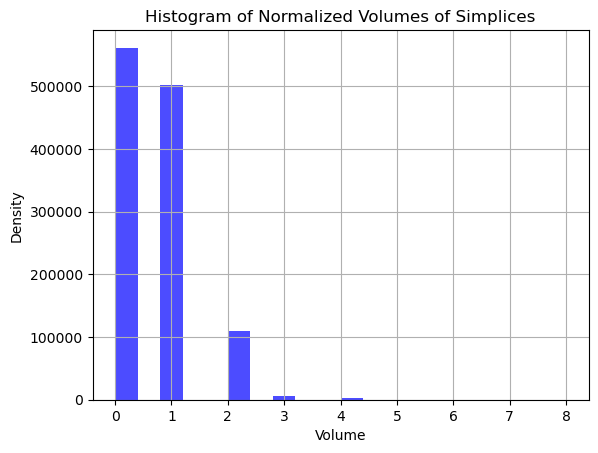

Unique volumes: [0, 1, 2, 3, 4, 8]


In [153]:
# For testing print a histogram of the normalized volumes of all the simplices
def print_volume_histogram(simplices):
    volumes = []
    unique_volumes = set()

    # Precompute pairwise squared distances
    P = np.array([FANO_POINTS[i] for i in range(len(FANO_POINTS))], dtype=np.float64) 
    D2 = np.sum((P[:, None, :] - P[None, :, :])**2, axis=2)

    for s in simplices:
        vol = round(cayley_menger_det(s, D2))
        volumes.append(vol)
        unique_volumes.add(round(vol))
    
    plt.hist(volumes, bins=20, density=False, alpha=0.7, color='blue')
    plt.title('Histogram of Normalized Volumes of Simplices')
    plt.xlabel('Volume')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
    print(f"Unique volumes: {sorted(unique_volumes)}")

print_volume_histogram(itertools.combinations(range(28), 7))

In [154]:
test = get_unimodular_simplices(FANO_POINTS, FANO_RANK)
print(f"Found {len(test)} unimodular simplices for the fano matroid polytope.")

Found 502624 unimodular simplices for the fano matroid polytope.


## 2. Compute the Chirotope

In [155]:
# Initialize the chirotope dictionary by computing the simplices

def initialize_chirotope(point_configuration, rank, tolerance=1e-13):
    n = len(point_configuration)
    chirotope = {}
    possible_simplices = itertools.combinations(range(n), rank)
    for comb in possible_simplices:
        simplex = tuple(comb)
        det = np.linalg.det(np.array([point_configuration[i] for i in simplex]))
        if abs(det) < tolerance:
            chirotope[simplex] = 0
        else:
            chirotope[simplex] = np.sign(det)
    return chirotope

### Testing

In [156]:
# print times for the mother and the fano examples
mother_start = time.time()
mother_chirotope = initialize_chirotope(MOTHER_POINTS, MOTHER_RANK)
mother_end = time.time()
print(f"Mother chirotope initialized in {mother_end - mother_start:.6f} seconds.")  
fano_start = time.time()
fano_chirotope = initialize_chirotope(FANO_POINTS, FANO_RANK)
fano_end = time.time()
print(f"Fano chirotope initialized in {fano_end - fano_start:.6f} seconds.")

Mother chirotope initialized in 0.000102 seconds.
Fano chirotope initialized in 4.506987 seconds.


## 3. Encode the Wall inequalities

In [183]:
# Get the list of simplex facets of the point configuration (every r - 1 subset of the non-zero chirotope simplices)
def get_simplex_facets(chirotope, rank):
    facets = []
    for simplex, sign in chirotope.items():
        if sign != 0:
            for facet in itertools.combinations(simplex, rank - 1):
                facets.append(facet)
    return sorted(list(set(facets))) # return unique facets

In [184]:
# Testing on the mother of all examples, print the simplex facets
mother_facets = get_simplex_facets(mother_chirotope, MOTHER_RANK)
print(f"Mother of all examples has {len(mother_facets)} facets.")
print(mother_facets)

Mother of all examples has 15 facets.
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [185]:
# Find the co-circuit signatures for each facet 
# Output a tuple of two lists for each simplex facet: negative and postive signatures
# The sign of the permutation is considered
def find_cocircuit_signatures(chirotope, facets, n):
    cocircuit_signatures = {}
    # for each facet, go through all vertices not in the facet
    # find the number of inversions (r - index of the vertex in the ordered simplex)
    r = len(facets[0]) + 1
    for facet in facets:
        negative_signatures = []
        positive_signatures = []
        facet_set = set(facet)
        for vertex in range(n):
            if vertex not in facet_set:
                # Create the full simplex by adding the vertex
                full_simplex = list(facet) + [vertex]
                full_simplex.sort()
                # Account for the sign of the permutation
                correction = (r - full_simplex.index(vertex)) % 2 
                sign = chirotope.get(tuple(full_simplex)) * (-1)**correction
                if sign == -1:
                    negative_signatures.append(vertex)
                elif sign == 1:
                    positive_signatures.append(vertex)
        cocircuit_signatures[facet] = (negative_signatures, positive_signatures)
    return cocircuit_signatures

In [186]:
# Testing on the mother of all examples, print the cocircuit signatures
mother_cocircuit_signatures = find_cocircuit_signatures(mother_chirotope, mother_facets, len(MOTHER_POINTS))
print("Mother of all examples cocircuit signatures:")
for facet, (neg, pos) in mother_cocircuit_signatures.items():
    print(f"Facet {facet}: Negative {neg}, Positive {pos}")

Mother of all examples cocircuit signatures:
Facet (0, 1): Negative [2, 3, 4, 5], Positive []
Facet (0, 2): Negative [], Positive [1, 3, 4, 5]
Facet (0, 3): Negative [2, 5], Positive [1, 4]
Facet (0, 4): Negative [2, 3, 5], Positive [1]
Facet (0, 5): Negative [2], Positive [1, 3, 4]
Facet (1, 2): Negative [0, 3, 4, 5], Positive []
Facet (1, 3): Negative [0], Positive [2, 4, 5]
Facet (1, 4): Negative [0, 3], Positive [2, 5]
Facet (1, 5): Negative [0, 3, 4], Positive [2]
Facet (2, 3): Negative [1, 4, 5], Positive [0]
Facet (2, 4): Negative [1], Positive [0, 3, 5]
Facet (2, 5): Negative [1, 4], Positive [0, 3]
Facet (3, 4): Negative [2, 5], Positive [0, 1]
Facet (3, 5): Negative [0, 2], Positive [1, 4]
Facet (4, 5): Negative [0, 3], Positive [1, 2]


In [187]:
# print the cocircuit signatures for the cube example
cube_chirotope = initialize_chirotope(CUBE_POINTS, CUBE_RANK)
cube_facets = get_simplex_facets(cube_chirotope, CUBE_RANK)
cube_cocircuit_signatures = find_cocircuit_signatures(cube_chirotope, cube_facets, len(CUBE_POINTS))
print("Cube example cocircuit signatures:")
for facet, (neg, pos) in cube_cocircuit_signatures.items():
    print(f"Facet {facet}: Negative {neg}, Positive {pos}")

Cube example cocircuit signatures:
Facet (0, 1, 2): Negative [], Positive [4, 5, 6, 7]
Facet (0, 1, 3): Negative [], Positive [4, 5, 6, 7]
Facet (0, 1, 4): Negative [2, 3, 6, 7], Positive []
Facet (0, 1, 5): Negative [2, 3, 6, 7], Positive []
Facet (0, 1, 6): Negative [2, 3], Positive [4, 5]
Facet (0, 1, 7): Negative [2, 3], Positive [4, 5]
Facet (0, 2, 3): Negative [4, 5, 6, 7], Positive []
Facet (0, 2, 4): Negative [], Positive [1, 3, 5, 7]
Facet (0, 2, 5): Negative [4, 6], Positive [1, 3]
Facet (0, 2, 6): Negative [], Positive [1, 3, 5, 7]
Facet (0, 2, 7): Negative [4, 6], Positive [1, 3]
Facet (0, 3, 4): Negative [2, 6], Positive [1, 5]
Facet (0, 3, 5): Negative [2, 4, 6, 7], Positive [1]
Facet (0, 3, 6): Negative [2], Positive [1, 4, 5, 7]
Facet (0, 3, 7): Negative [2, 6], Positive [1, 5]
Facet (0, 4, 5): Negative [], Positive [2, 3, 6, 7]
Facet (0, 4, 6): Negative [1, 3, 5, 7], Positive []
Facet (0, 4, 7): Negative [1, 5], Positive [2, 6]
Facet (0, 5, 6): Negative [1, 2, 3, 7], P

## 4. Encode the Flag inequalities

## 5. Optimize

# Running examples

## 1. The mother of all examples (2D)

## 2. The Fano Matroid Polytope (3D)